In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/playground-series-s3e24/sample_submission.csv
/kaggle/input/playground-series-s3e24/train.csv
/kaggle/input/playground-series-s3e24/test.csv


In [2]:
import matplotlib.pyplot as plt

from xgboost import XGBClassifier
from catboost import CatBoostClassifier
import lightgbm as lgb
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import VotingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import KFold, cross_validate, GridSearchCV
from sklearn.metrics import make_scorer, roc_auc_score, log_loss
from sklearn.model_selection import learning_curve
from sklearn.pipeline import Pipeline

# Data import and a little insight

In [3]:
train_df = pd.read_csv("/kaggle/input/playground-series-s3e24/train.csv")
test_df = pd.read_csv("/kaggle/input/playground-series-s3e24/test.csv")

In [4]:
test_id = test_df["id"]

In [5]:
train_df

,id,age,height(cm),weight(kg),waist(cm),eyesight(left),eyesight(right),hearing(left),hearing(right),systolic,...,HDL,LDL,hemoglobin,Urine protein,serum creatinine,AST,ALT,Gtp,dental caries,smoking
0,0,55,165,60,81.0,0.5,0.6,1,1,135,...,40,75,16.5,1,1.0,22,25,27,0,1
1,1,70,165,65,89.0,0.6,0.7,2,2,146,...,57,126,16.2,1,1.1,27,23,37,1,0
2,2,20,170,75,81.0,0.4,0.5,1,1,118,...,45,93,17.4,1,0.8,27,31,53,0,1
3,3,35,180,95,105.0,1.5,1.2,1,1,131,...,38,102,15.9,1,1.0,20,27,30,1,0
4,4,30,165,60,80.5,1.5,1.0,1,1,121,...,44,93,15.4,1,0.8,19,13,17,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
159251,159251,40,155,45,69.0,1.5,2.0,1,1,127,...,72,159,14.5,1,0.8,25,26,13,0,0
159252,159252,50,155,75,82.0,1.0,1.0,1,1,120,...,64,108,14.5,1,0.6,21,20,18,0,0
159253,159253,40,160,50,66.0,1.5,1.0,1,1,114,...,87,93,10.9,1,0.6,15,9,12,0,0
159254,159254,50,165,75,92.0,1.2,1.0,1,1,121,...,55,80,14.4,1,1.1,22,17,37,0,1


In [6]:
train_df.describe()

,id,age,height(cm),weight(kg),waist(cm),eyesight(left),eyesight(right),hearing(left),hearing(right),systolic,...,HDL,LDL,hemoglobin,Urine protein,serum creatinine,AST,ALT,Gtp,dental caries,smoking
count,159256.000000,159256.000000,159256.000000,159256.000000,159256.000000,159256.000000,159256.000000,159256.000000,159256.000000,159256.000000,...,159256.000000,159256.000000,159256.000000,159256.000000,159256.000000,159256.000000,159256.000000,159256.000000,159256.000000,159256.000000
mean,79627.500000,44.306626,165.266929,67.143662,83.001990,1.005798,1.000989,1.023974,1.023421,122.503648,...,55.852684,114.607682,14.796965,1.074233,0.892764,25.516853,26.550296,36.216004,0.197996,0.437365
std,45973.391572,11.842286,8.818970,12.586198,8.957937,0.402113,0.392299,0.152969,0.151238,12.729315,...,13.964141,28.158931,1.431213,0.347856,0.179346,9.464882,17.753070,31.204643,0.398490,0.496063
min,0.000000,20.000000,135.000000,30.000000,51.000000,0.100000,0.100000,1.000000,1.000000,77.000000,...,9.000000,1.000000,4.900000,1.000000,0.100000,6.000000,1.000000,2.000000,0.000000,0.000000
25%,39813.750000,40.000000,160.000000,60.000000,77.000000,0.800000,0.800000,1.000000,1.000000,114.000000,...,45.000000,95.000000,13.800000,1.000000,0.800000,20.000000,16.000000,18.000000,0.000000,0.000000
50%,79627.500000,40.000000,165.000000,65.000000,83.000000,1.000000,1.000000,1.000000,1.000000,121.000000,...,54.000000,114.000000,15.000000,1.000000,0.900000,24.000000,22.000000,27.000000,0.000000,0.000000
75%,119441.250000,55.000000,170.000000,75.000000,89.000000,1.200000,1.200000,1.000000,1.000000,130.000000,...,64.000000,133.000000,15.800000,1.000000,1.000000,29.000000,32.000000,44.000000,0.000000,1.000000
max,159255.000000,85.000000,190.000000,130.000000,127.000000,9.900000,9.900000,2.000000,2.000000,213.000000,...,136.000000,1860.000000,21.000000,6.000000,9.900000,778.000000,2914.000000,999.000000,1.000000,1.000000


In [7]:
train_df.columns

Index(['id', 'age', 'height(cm)', 'weight(kg)', 'waist(cm)', 'eyesight(left)',
       'eyesight(right)', 'hearing(left)', 'hearing(right)', 'systolic',
       'relaxation', 'fasting blood sugar', 'Cholesterol', 'triglyceride',
       'HDL', 'LDL', 'hemoglobin', 'Urine protein', 'serum creatinine', 'AST',
       'ALT', 'Gtp', 'dental caries', 'smoking'],
      dtype='object')

In [8]:
train_df.isnull().sum()

id                     0
age                    0
height(cm)             0
weight(kg)             0
waist(cm)              0
eyesight(left)         0
eyesight(right)        0
hearing(left)          0
hearing(right)         0
systolic               0
relaxation             0
fasting blood sugar    0
Cholesterol            0
triglyceride           0
HDL                    0
LDL                    0
hemoglobin             0
Urine protein          0
serum creatinine       0
AST                    0
ALT                    0
Gtp                    0
dental caries          0
smoking                0
dtype: int64

Normally (and with my personal experience), these features can tells if a person is smoking or not:

- Blood creatinine + urine protein (kidney diseases)
- Blood sugar + eyesight (diabetes)
- Systolic BP - high BP

To be sure, I'll need to run PCA on all 24 features.

In [9]:
def preprocessing(df):
    # Calculate BMI
#     df["BMI"] = df["weight(kg)"] / ((df["height(cm)"] / 100) ** 2)
    
#     # Calculate eGFR (for kidney disease)
#     df["eGFR"] = (140 - df["age"]) * df["weight(kg)"] / (72 * df["serum creatinine"])
    
    df = df.drop([
        "id",
#         "age",
#         "weight(kg)",
#         "height(cm)",
#         "serum creatinine"
    ], axis=1)
    
    return df

In [10]:
train_df = preprocessing(train_df)
test_df = preprocessing(test_df)

In [11]:
train_df

,age,height(cm),weight(kg),waist(cm),eyesight(left),eyesight(right),hearing(left),hearing(right),systolic,relaxation,...,HDL,LDL,hemoglobin,Urine protein,serum creatinine,AST,ALT,Gtp,dental caries,smoking
0,55,165,60,81.0,0.5,0.6,1,1,135,87,...,40,75,16.5,1,1.0,22,25,27,0,1
1,70,165,65,89.0,0.6,0.7,2,2,146,83,...,57,126,16.2,1,1.1,27,23,37,1,0
2,20,170,75,81.0,0.4,0.5,1,1,118,75,...,45,93,17.4,1,0.8,27,31,53,0,1
3,35,180,95,105.0,1.5,1.2,1,1,131,88,...,38,102,15.9,1,1.0,20,27,30,1,0
4,30,165,60,80.5,1.5,1.0,1,1,121,76,...,44,93,15.4,1,0.8,19,13,17,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
159251,40,155,45,69.0,1.5,2.0,1,1,127,80,...,72,159,14.5,1,0.8,25,26,13,0,0
159252,50,155,75,82.0,1.0,1.0,1,1,120,80,...,64,108,14.5,1,0.6,21,20,18,0,0
159253,40,160,50,66.0,1.5,1.0,1,1,114,70,...,87,93,10.9,1,0.6,15,9,12,0,0
159254,50,165,75,92.0,1.2,1.0,1,1,121,90,...,55,80,14.4,1,1.1,22,17,37,0,1


In [12]:
# train_df["serum creatinine"].describe()

In [13]:
# train_df[(train_df["eGFR"] > 120) & (train_df["smoking"] == 1)]

In [14]:
# train_df["eGFR"].describe()

In [15]:
# train_df["serum creatinine"]

In [16]:
# train_df[train_df["smoking"] == 1].plot.scatter(x = "Urine protein", y = "serum creatinine")
# plt.show()

In [17]:
# train_df[train_df["smoking"] == 1].plot.scatter(x = "eGFR", y = "BMI")
# plt.plot()

In [18]:
train_X = train_df.drop(["smoking"], axis=1)
train_y = train_df["smoking"]

In [19]:
from sklearn.preprocessing import StandardScaler

sc = StandardScaler()
train_X_std = sc.fit_transform(train_X)

In [20]:
from sklearn.decomposition import PCA

In [21]:
pca = PCA()
train_X_PCA = pca.fit_transform(train_X_std)

In [22]:
exp_var_pca = pca.explained_variance_ratio_
cum_sum_eigenvalues = np.cumsum(exp_var_pca)

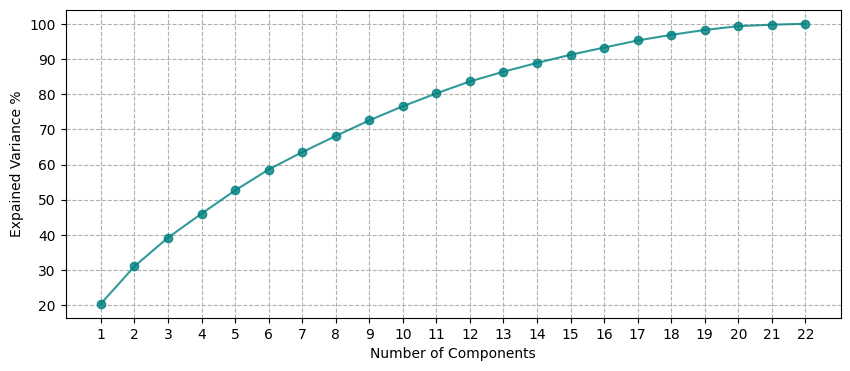

In [23]:
fig = plt.figure(figsize = (10,4))
plt.plot(np.arange(1, train_X_std.shape[1]+1),100 * cum_sum_eigenvalues, marker = 'o',
         color = 'teal', alpha = .8)
plt.xticks(np.arange(1, train_X_std.shape[1]+1),np.arange(1, train_X_std.shape[1]+1))
plt.xlabel('Number of Components')
plt.ylabel('Expained Variance %')
plt.grid(linestyle = '--')

plt.show()

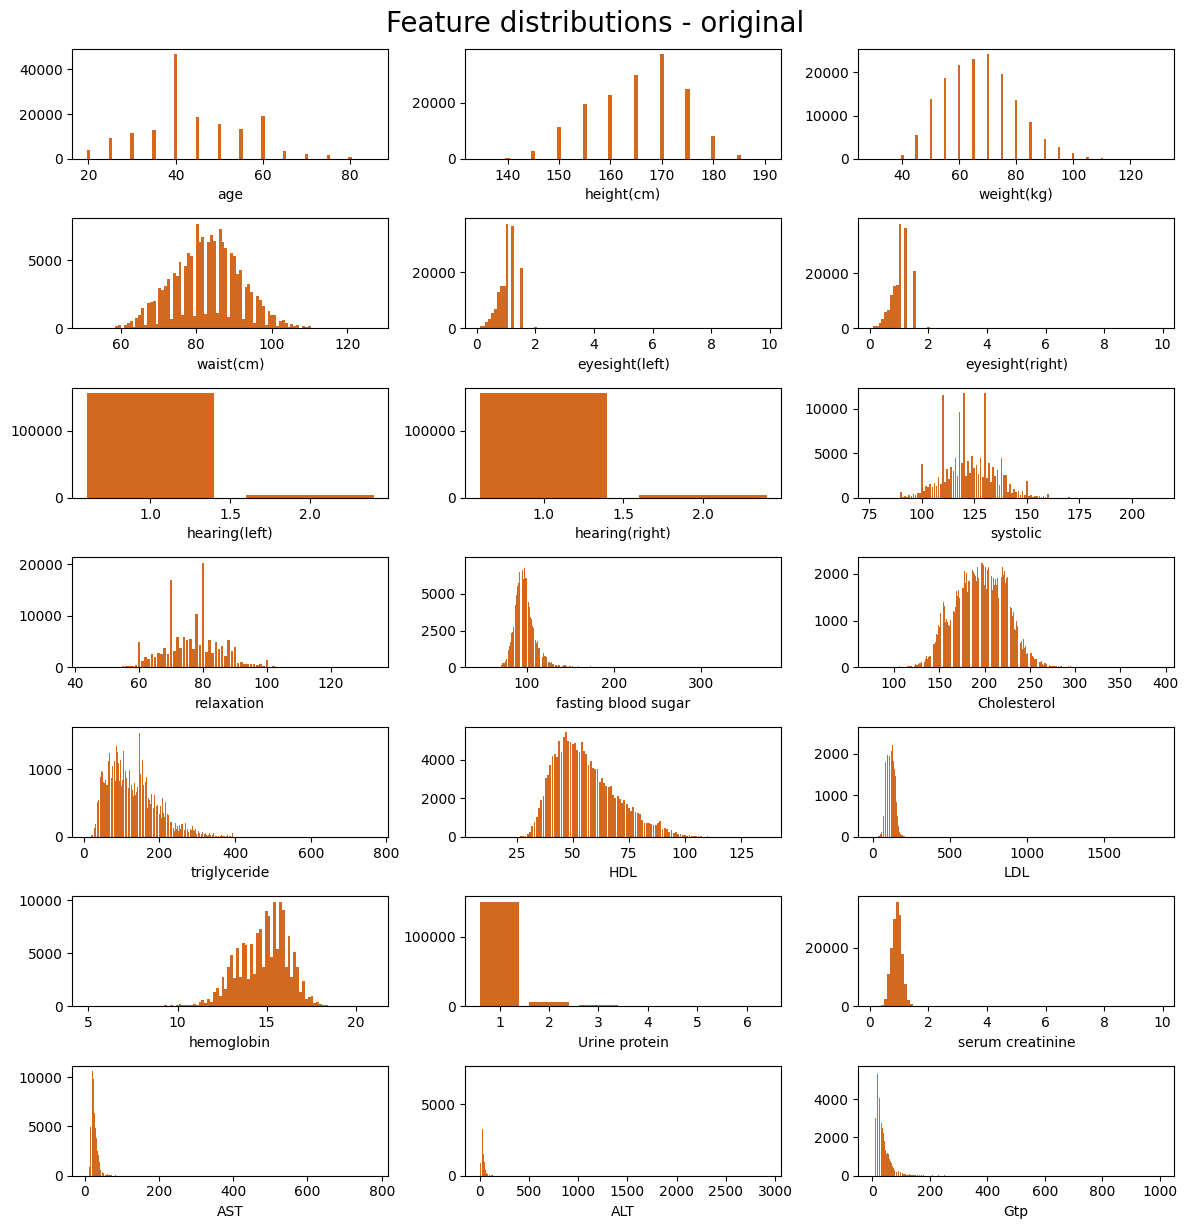

In [24]:
_, axs = plt.subplots(7, 3, figsize=(12, 12))
for col, ax in zip(train_X.columns, axs.ravel()):
    if train_X[col].dtype == float:
        ax.hist(train_X[col], bins=100, color='chocolate')
    else: #int
        vc = train_X[col].value_counts()
        ax.bar(vc.index, vc, color='chocolate')
    ax.set_xlabel(col)
plt.tight_layout()
plt.suptitle('Feature distributions - original', y=1.02, fontsize=20)
plt.show()

So the best option is to use all? True!

In [25]:
import seaborn as sns

In [26]:
estimators = [
#     ("lr", LogisticRegression()),
#     ("xgb", XGBClassifier()),
    ("lgb", lgb.LGBMClassifier(
            min_child_samples=70,
            n_estimators=700
        )
    ),
#     ("gb", GradientBoostingClassifier()),
    ("cat", CatBoostClassifier(
            depth=6,
            l2_leaf_reg=4,
        )
    )
]

In [27]:
pipes = {}

for model in estimators:
    print(f"Fitting {model[0]}")
    
    pipe = Pipeline(steps=[
        ("std_scaler", StandardScaler()),
        model
    ])
    pipe.fit(train_X, train_y)
    pipes[pipe.steps[1][0]] = pipe

Fitting lgb
Fitting cat
0:	learn: 0.6775828	total: 89.7ms	remaining: 1m 29s
1:	learn: 0.6631892	total: 121ms	remaining: 1m
2:	learn: 0.6504113	total: 155ms	remaining: 51.5s
3:	learn: 0.6387169	total: 187ms	remaining: 46.7s
4:	learn: 0.6271965	total: 218ms	remaining: 43.4s
5:	learn: 0.6165554	total: 247ms	remaining: 40.9s
6:	learn: 0.6068780	total: 275ms	remaining: 39.1s
7:	learn: 0.5980372	total: 308ms	remaining: 38.2s
8:	learn: 0.5900725	total: 337ms	remaining: 37.1s
9:	learn: 0.5826498	total: 367ms	remaining: 36.3s
10:	learn: 0.5756714	total: 396ms	remaining: 35.6s
11:	learn: 0.5690858	total: 424ms	remaining: 34.9s
12:	learn: 0.5630450	total: 453ms	remaining: 34.4s
13:	learn: 0.5576091	total: 481ms	remaining: 33.9s
14:	learn: 0.5523002	total: 510ms	remaining: 33.5s
15:	learn: 0.5478586	total: 542ms	remaining: 33.3s
16:	learn: 0.5435420	total: 572ms	remaining: 33.1s
17:	learn: 0.5394431	total: 601ms	remaining: 32.8s
18:	learn: 0.5357638	total: 632ms	remaining: 32.6s
19:	learn: 0.53215

In [28]:
estimator_names = [model[0] for model in estimators]

In [29]:
def plot_estimators(estimators=estimator_names, 
                    X=train_X,
                    y=train_y,
                   n_splits=5,
                   metrics=["auc", "log_loss"]):
    metrics = {
        key: _metrics[key] for key in metrics
    }
    
    scorer, labels = [], []
    
    for pipe_name in pipes.keys():
        if pipe_name in estimators:
            pipe = pipes[pipe_name]
            
            print(pipe)
            
            labels.append(pipe_name)
            
            kf = KFold(n_splits)
            
            model_score = cross_validate(pipe, X, y, scoring=metrics, cv=kf, n_jobs=4)
            
            scorer.append(model_score)
    
    score_lists = {}
    
    for metric in metrics:
        score_lists[metric] = [score[f"test_{metric}"] for score in scorer]
        
    for i, (title, _list) in enumerate(score_lists.items()):
        plt.figure(i)
        plot = sns.boxplot(data=_list).set_xticklabels(labels, rotation=45)
        plt.title(title)

In [30]:
metrics = {
    "auc": make_scorer(roc_auc_score, needs_proba=True),
    "log_loss": make_scorer(log_loss)
}

_metrics = {
    "auc": make_scorer(roc_auc_score, needs_proba=True),
    "log_loss": make_scorer(log_loss)
}

Pipeline(steps=[('std_scaler', StandardScaler()),
                ('lgb',
                 LGBMClassifier(min_child_samples=70, n_estimators=700))])
Pipeline(steps=[('std_scaler', StandardScaler()),
                ('cat',
                 <catboost.core.CatBoostClassifier object at 0x7e770b594c70>)])


TBB Warning: The number of workers is currently limited to 0. The request for 3 workers is ignored. Further requests for more workers will be silently ignored until the limit changes.

TBB Warning: The number of workers is currently limited to 0. The request for 3 workers is ignored. Further requests for more workers will be silently ignored until the limit changes.

TBB Warning: The number of workers is currently limited to 0. The request for 3 workers is ignored. Further requests for more workers will be silently ignored until the limit changes.



0:	learn: 0.6776658	total: 273ms	remaining: 4m 32s
1:	learn: 0.6632278	total: 477ms	remaining: 3m 58s
2:	learn: 0.6507289	total: 685ms	remaining: 3m 47s
3:	learn: 0.6385444	total: 887ms	remaining: 3m 40s
4:	learn: 0.6270412	total: 1.09s	remaining: 3m 37s
5:	learn: 0.6163848	total: 1.3s	remaining: 3m 35s
6:	learn: 0.6069512	total: 1.49s	remaining: 3m 32s
7:	learn: 0.5983684	total: 1.7s	remaining: 3m 30s
8:	learn: 0.5900878	total: 1.9s	remaining: 3m 29s
9:	learn: 0.5828367	total: 2.12s	remaining: 3m 29s
10:	learn: 0.5759398	total: 2.32s	remaining: 3m 28s
11:	learn: 0.5693568	total: 2.54s	remaining: 3m 29s
12:	learn: 0.5635525	total: 2.74s	remaining: 3m 28s
13:	learn: 0.5578385	total: 2.94s	remaining: 3m 27s
14:	learn: 0.5525988	total: 3.15s	remaining: 3m 27s
15:	learn: 0.5482883	total: 3.36s	remaining: 3m 26s
16:	learn: 0.5437684	total: 3.56s	remaining: 3m 25s
17:	learn: 0.5395752	total: 3.74s	remaining: 3m 24s
18:	learn: 0.5357736	total: 3.94s	remaining: 3m 23s
19:	learn: 0.5323368	tota

TBB Warning: The number of workers is currently limited to 0. The request for 3 workers is ignored. Further requests for more workers will be silently ignored until the limit changes.



928:	learn: 0.4283219	total: 2m 49s	remaining: 13s
929:	learn: 0.4283211	total: 2m 49s	remaining: 12.8s
930:	learn: 0.4282959	total: 2m 50s	remaining: 12.6s
931:	learn: 0.4282737	total: 2m 50s	remaining: 12.4s
932:	learn: 0.4282479	total: 2m 50s	remaining: 12.2s
933:	learn: 0.4282471	total: 2m 50s	remaining: 12.1s
934:	learn: 0.4282207	total: 2m 50s	remaining: 11.9s
935:	learn: 0.4281989	total: 2m 50s	remaining: 11.7s
936:	learn: 0.4281784	total: 2m 51s	remaining: 11.5s
937:	learn: 0.4281588	total: 2m 51s	remaining: 11.3s
938:	learn: 0.4281335	total: 2m 51s	remaining: 11.1s
939:	learn: 0.4281071	total: 2m 51s	remaining: 11s
940:	learn: 0.4280855	total: 2m 51s	remaining: 10.8s
941:	learn: 0.4280570	total: 2m 52s	remaining: 10.6s
942:	learn: 0.4280397	total: 2m 52s	remaining: 10.4s
943:	learn: 0.4280190	total: 2m 52s	remaining: 10.2s
944:	learn: 0.4279970	total: 2m 52s	remaining: 10s
945:	learn: 0.4279738	total: 2m 52s	remaining: 9.87s
946:	learn: 0.4279572	total: 2m 52s	remaining: 9.68s

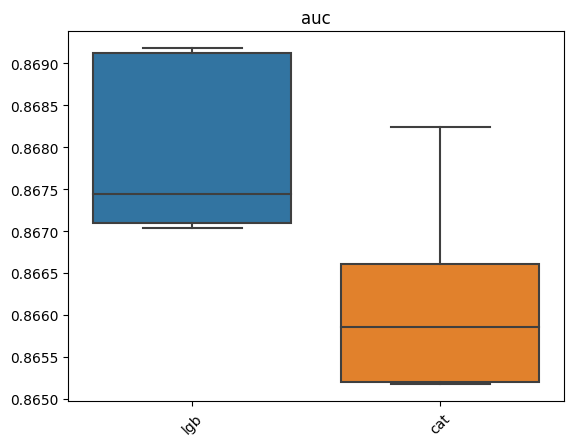

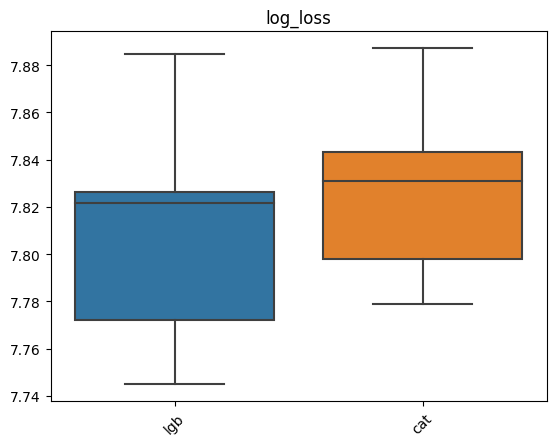

In [31]:
plot_estimators()

In [32]:
def tune_param(model, 
               param_grid, 
               refit="auc", 
               chart=None, 
               X=train_X, 
               y=train_y, cv=5):
    param_grid = {
        f"{model}__{key}" : param_grid[key]
        for key in param_grid.keys()
    }
    
    grid_cv = GridSearchCV(
        pipes[model],
        param_grid,
        scoring=metrics,
        refit=refit,
        return_train_score=True,
        cv=cv,
        n_jobs=4,
        verbose=3
    )
    
    grid_cv.fit(X, y)
    
    print(f"Best score: { grid_cv.best_score_ }")
    print(f"Best params: { grid_cv.best_params_ }")
    
    results = pd.DataFrame(grid_cv.cv_results_)
    
    if "line" in chart:
        for i, param in enumerate(param_grid.keys()):
            graph_data = results[[
                f"param_{param}",
                f"mean_test_{refit}",
                f"mean_train_{refit}"
            ]]
            
            graph_data = graph_data.rename(columns = {
                f"mean_test_{refit}" : "test",
                f"mean_train_{refit}" : "train",
            })
            
            graph_data = graph_data.melt(f"param_{param}", var_name="type", value_name=refit)
            plt.figure(i)
            plot = sns.lineplot(x=f"param_{param}", y=refit, hue="type", data=graph_data)
    
    if "heatmap" in chart:
        param1 = list(param_grid.keys())[0]
        param2 = list(param_grid.keys())[1]
        
        graph_data = results[[
            f"param_{param1}",
            f"param_{param2}",
            f"mean_test_{refit}"
        ]]
        
        graph_data = graph_data.pivot(index=f"param_{param1}", 
                                      columns=f"param_{param2}", 
                                     values=f"mean_test_{refit}")
        
        sns.heatmap(graph_data, annot=True, xticklabels=True, yticklabels=True).set(
            xlabel=param2,
            ylabel=param1
        )

Tuning CatBoostingClassifier

In [33]:
# param_grid = {
#     'depth': [i for i in range(4, 11)],
# }
# tune_param('cat', param_grid, chart="line")

In [34]:
# pipes["cat"].set_params(**{
#     "cat__depth": 6,
# })

In [35]:
# param_grid = {
#     'l2_leaf_reg': [i for i in range(2, 11, 1)],
# }
# tune_param('cat', param_grid, chart="line")

In [36]:
# pipes["cat"].set_params(**{
#     "cat__min_child_samples": 500,
# })

Tuning LGBM

In [37]:
# pipes['lgb'].named_steps['lgb'].get_params()

In [38]:
# param_grid = {
#     'min_child_samples': [i for i in range(10, 110, 10)],
# }
# tune_param('lgb', param_grid, chart="line")

In [39]:
# pipes["lgb"].set_params(**{
#     "lgb__min_child_samples": 70,
# })

In [40]:
# param_grid = {
#     'n_estimators': [i for i in range(100, 1000, 100)],
# }
# tune_param('lgb', param_grid, chart="line")

In [41]:
# pipes["lgb"].set_params(**{
#     "lgb__n_estimators": 700,
# })

In [42]:
# param_grid = {
#     'boosting_type': ["gbdt", "dart", "goss"],
# }
# tune_param('lgb', param_grid, chart="line")

Plotting learning curve

In [43]:
def plot_learning_curve(estimator, title, X, y, ylim=None, cv=None, n_jobs=-1, train_sizes=np.linspace(.1, 1.0, 5)):
    plt.figure()
    plt.title(title)
    if ylim is not None:
        plt.ylim(*ylim)
    plt.xlabel("Training examples")
    plt.ylabel("Score")
    train_sizes, train_scores, test_scores = learning_curve(
        estimator, X, y, cv=cv, n_jobs=n_jobs, train_sizes=train_sizes)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    plt.grid()

    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1,
                     color="r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="g")
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r",
             label="Training score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g",
             label="Cross-validation score")

    plt.legend(loc="best")
    return plt

Plotting lgb
Plotting cat
929:	learn: 0.4281257	total: 2m 51s	remaining: 12.9s
930:	learn: 0.4281106	total: 2m 51s	remaining: 12.7s
931:	learn: 0.4280915	total: 2m 51s	remaining: 12.5s
932:	learn: 0.4280688	total: 2m 51s	remaining: 12.3s
933:	learn: 0.4280416	total: 2m 51s	remaining: 12.1s
934:	learn: 0.4280182	total: 2m 51s	remaining: 12s
935:	learn: 0.4279987	total: 2m 52s	remaining: 11.8s
936:	learn: 0.4279808	total: 2m 52s	remaining: 11.6s
937:	learn: 0.4279671	total: 2m 52s	remaining: 11.4s
938:	learn: 0.4279448	total: 2m 52s	remaining: 11.2s
939:	learn: 0.4279386	total: 2m 52s	remaining: 11s
940:	learn: 0.4279234	total: 2m 53s	remaining: 10.8s
941:	learn: 0.4279011	total: 2m 53s	remaining: 10.7s
942:	learn: 0.4278849	total: 2m 53s	remaining: 10.5s
943:	learn: 0.4278562	total: 2m 53s	remaining: 10.3s
944:	learn: 0.4278333	total: 2m 53s	remaining: 10.1s
945:	learn: 0.4278163	total: 2m 53s	remaining: 9.93s
946:	learn: 0.4278030	total: 2m 54s	remaining: 9.74s
947:	learn: 0.4277868	to

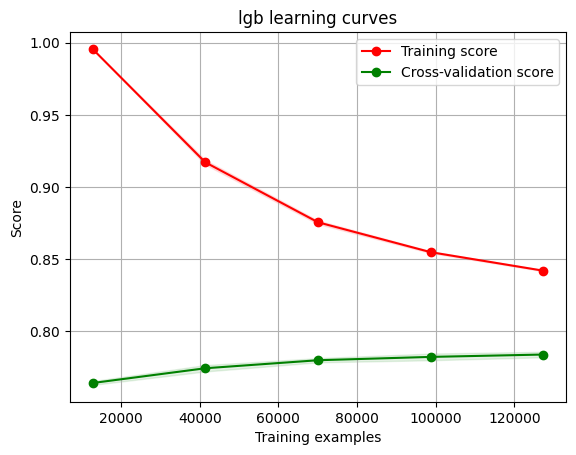

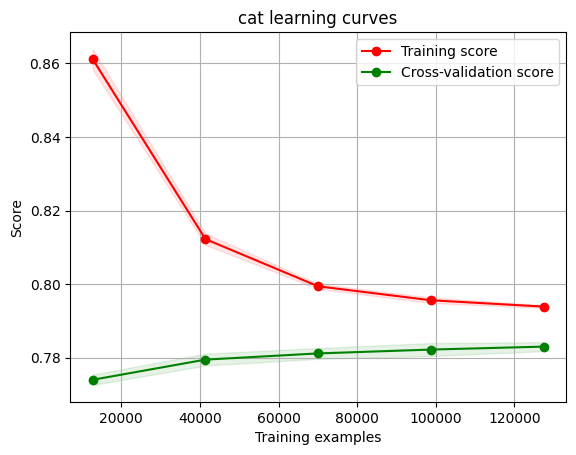

In [44]:
to_plot = [
#     "xgb",
    "lgb",
#     "gb",
#     "lr",
    "cat"
]

for name in pipes.keys():
    if name in to_plot:
        print(f"Plotting {name}")
        g = plot_learning_curve(
            pipes[name].named_steps[name],
            f"{name} learning curves",
            train_X_std,
            train_y,
            cv=KFold(5),
            n_jobs=4
        )

<Axes: >

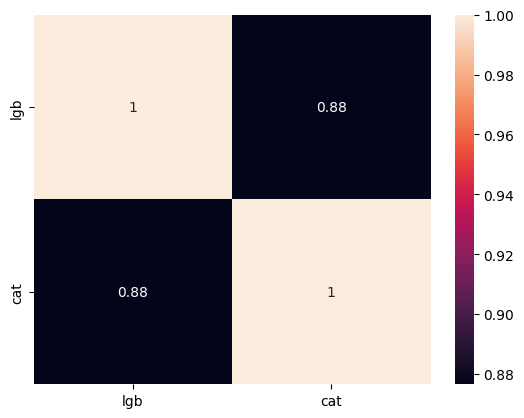

In [45]:
ensemble_results = pd.DataFrame()

for name, pipe in pipes.items():
    ensemble_results[name] = pipe.predict(train_X)
    
sns.heatmap(ensemble_results.corr(), annot=True)

## Voting

In [46]:
vote = Pipeline([
    ("std_scaler", StandardScaler()),
    ("voter", VotingClassifier(estimators, 
                               voting="soft", 
                               n_jobs=4))
], verbose=True)

In [47]:
vote.fit(train_X, train_y)

[Pipeline] ........ (step 1 of 2) Processing std_scaler, total=   0.1s
912:	learn: 0.4212683	total: 2m 9s	remaining: 12.4s
913:	learn: 0.4212476	total: 2m 9s	remaining: 12.2s
914:	learn: 0.4212166	total: 2m 9s	remaining: 12.1s
915:	learn: 0.4212052	total: 2m 9s	remaining: 11.9s
916:	learn: 0.4211940	total: 2m 10s	remaining: 11.8s
917:	learn: 0.4211716	total: 2m 10s	remaining: 11.6s
918:	learn: 0.4211378	total: 2m 10s	remaining: 11.5s
919:	learn: 0.4211029	total: 2m 10s	remaining: 11.3s
920:	learn: 0.4210641	total: 2m 10s	remaining: 11.2s
921:	learn: 0.4210405	total: 2m 10s	remaining: 11s
922:	learn: 0.4210166	total: 2m 10s	remaining: 10.9s
923:	learn: 0.4209802	total: 2m 10s	remaining: 10.8s
924:	learn: 0.4209524	total: 2m 10s	remaining: 10.6s
925:	learn: 0.4209200	total: 2m 10s	remaining: 10.5s
926:	learn: 0.4209032	total: 2m 11s	remaining: 10.3s
927:	learn: 0.4208836	total: 2m 11s	remaining: 10.2s
928:	learn: 0.4208681	total: 2m 11s	remaining: 10s
929:	learn: 0.4208353	total: 2m 11s	

Pipeline(steps=[('std_scaler', StandardScaler()),
                ('voter',
                 VotingClassifier(estimators=[('lgb',
                                               LGBMClassifier(min_child_samples=70,
                                                              n_estimators=700)),
                                              ('cat',
                                               <catboost.core.CatBoostClassifier object at 0x7e770b594c70>)],
                                  n_jobs=4, voting='soft'))],
         verbose=True)

In [48]:
pred_probs = vote.predict_proba(test_df)[:, 1]

In [49]:
pred_probs

array([0.60506276, 0.30408542, 0.39834495, ..., 0.42205481, 0.08852753,
       0.02370708])

In [50]:
submission_df = pd.DataFrame({
    "id": test_id,
    "defects": pred_probs
})

submission_df

,id,defects
0,159256,0.605063
1,159257,0.304085
2,159258,0.398345
3,159259,0.016755
4,159260,0.614315
...,...,...
106166,265422,0.593641
106167,265423,0.581485
106168,265424,0.422055
106169,265425,0.088528


In [51]:
submission_df.to_csv("submission.csv", index=False)